In [13]:
#https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html
#first walkthrough python hdbscan instructions

In [1]:
import pandas as pd
import numpy as np
import hdbscan
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()

In [2]:
df = pd.read_csv('test files\detected_results.csv')

In [3]:
df = df.reset_index()
df.insert(0, 'cell_index', df['index'].apply(lambda x:'cell_'+str(x)))
df = df.drop(columns='index')

In [4]:
#calculate channel value as relative to channel max value
df['rel_red'] = df['channel_red']/df['channel_red'].max()
df['rel_green'] = df['channel_green']/df['channel_green'].max()
df['rel_blue'] = df['channel_blue']/df['channel_blue'].max()

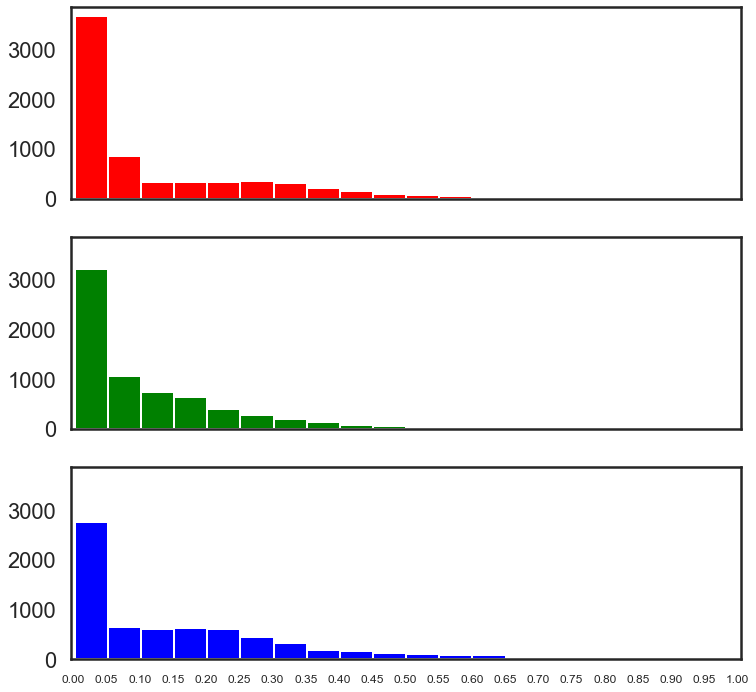

In [5]:
#want to remove some of the low value noise with a minimum threshold
#show channels as histograms

fig, axs = plt.subplots(3, sharex=True, sharey=True,figsize=(12,12))
axs[0].hist(df['rel_red'],bins=20,color='red')
axs[1].hist(df['rel_green'],bins=20,color='green')
axs[2].hist(df['rel_blue'],bins=20,color='blue')
plt.xticks(np.arange(0, 1+0.05, step=0.05))
plt.tick_params(axis = 'x', labelsize=12)
plt.margins(x=0.005)

plt.show()

In [6]:
#set minium value threshold and filter df
threshhold = 0.2
red = df['rel_red'] > threshhold
green = df['rel_green'] > threshhold
blue = df['rel_blue'] > threshhold
df2 = df[red & green & blue].reset_index()

#convert to np matrix
rgb_data = df2[['rel_red', 'rel_green', 'rel_blue']].to_numpy()

In [7]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)
clusterer.fit(rgb_data)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_epsilon=0.0,
        cluster_selection_method='eom', core_dist_n_jobs=4,
        gen_min_span_tree=True, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=5, min_samples=None, p=None,
        prediction_data=False)

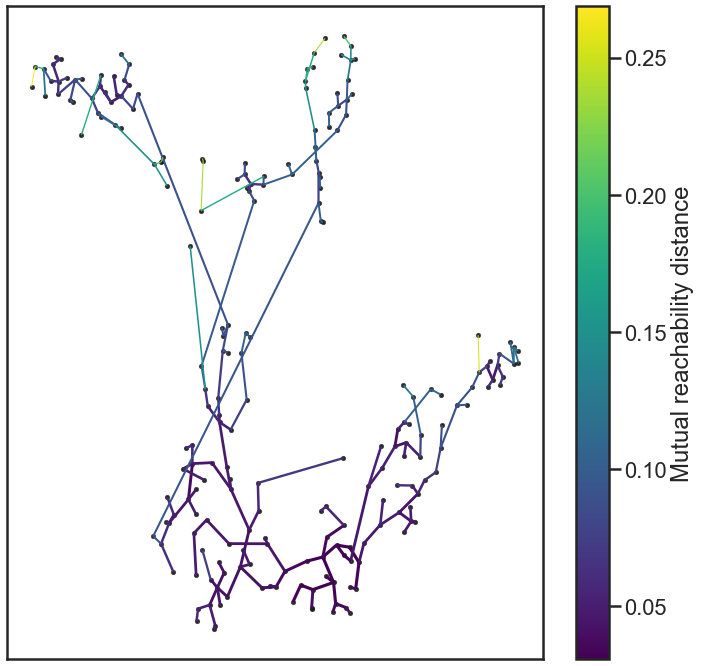

In [8]:
plt.figure(figsize=(12,12))
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                      edge_alpha=1,
                                      node_size=10,
                                      edge_linewidth=1)

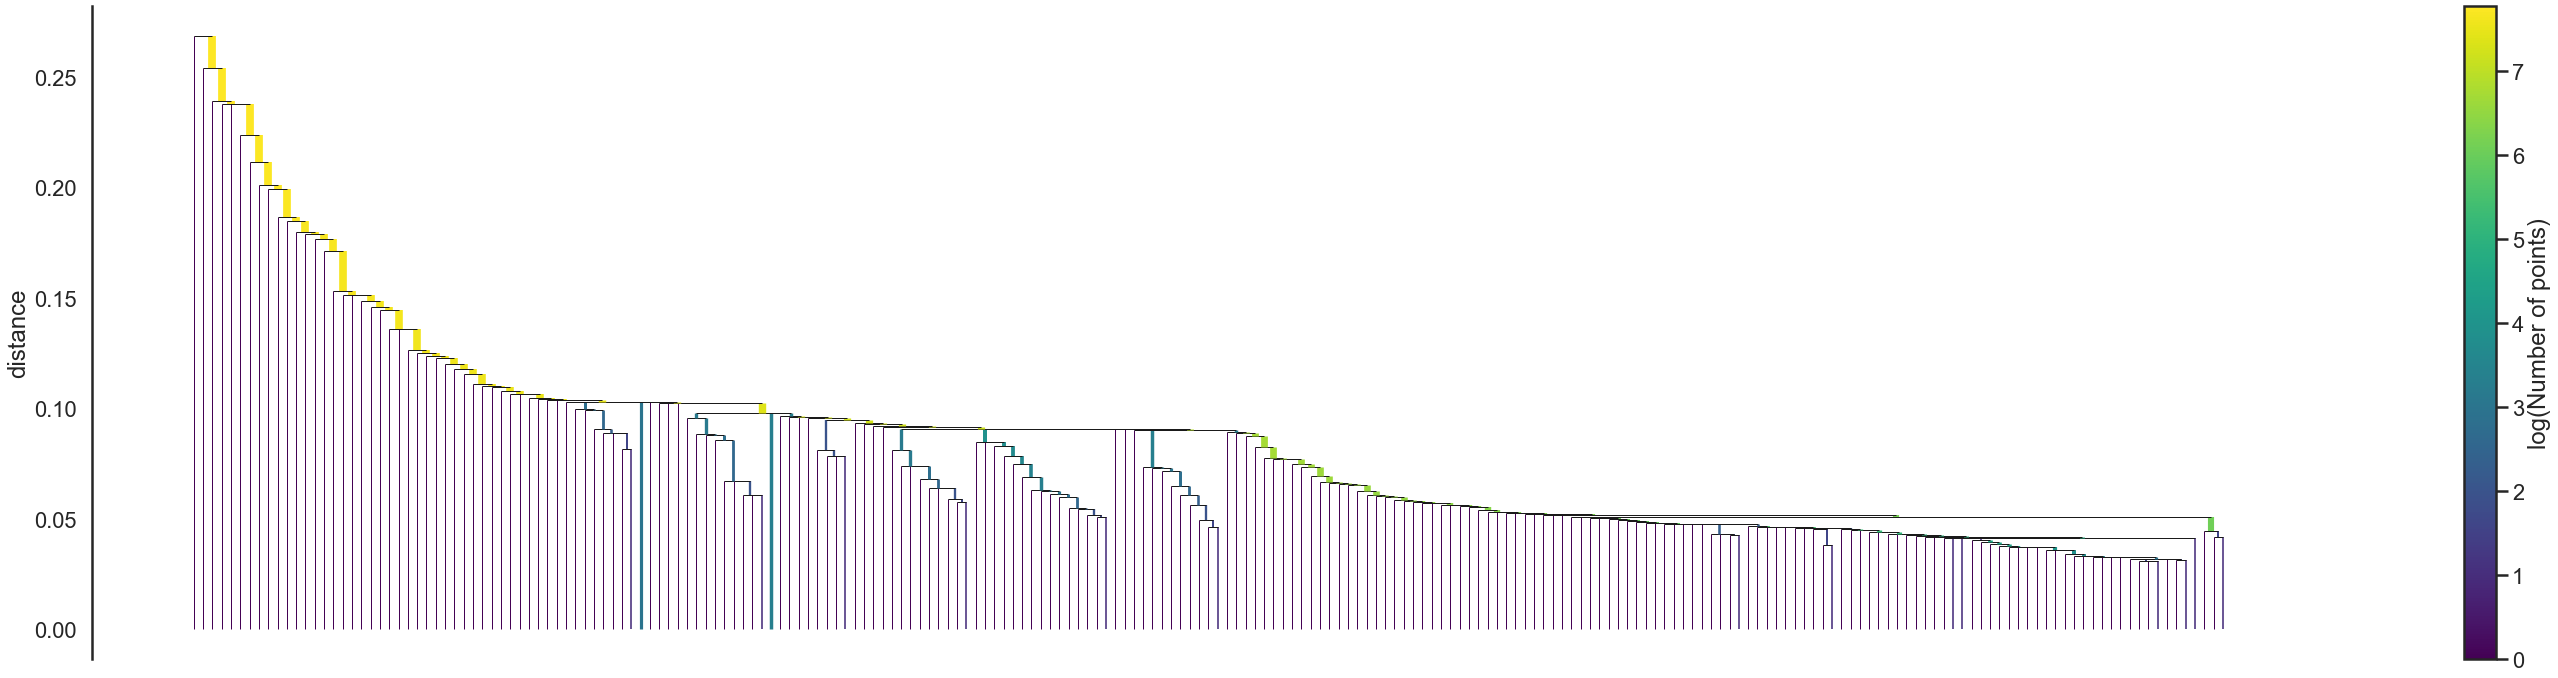

In [9]:
#cannot compute above limit
#single linkege plot needs threshold filter applied
plt.figure(figsize=(50,12))
clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

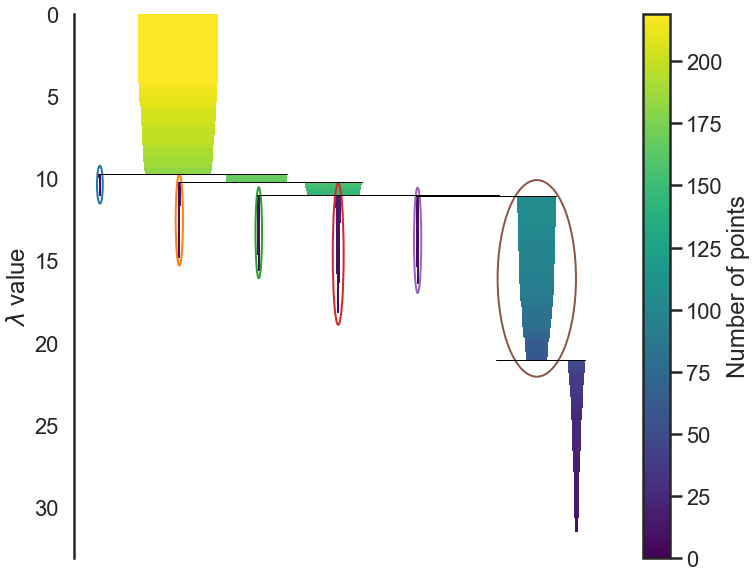

In [10]:
plt.figure(figsize=(12,10))
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

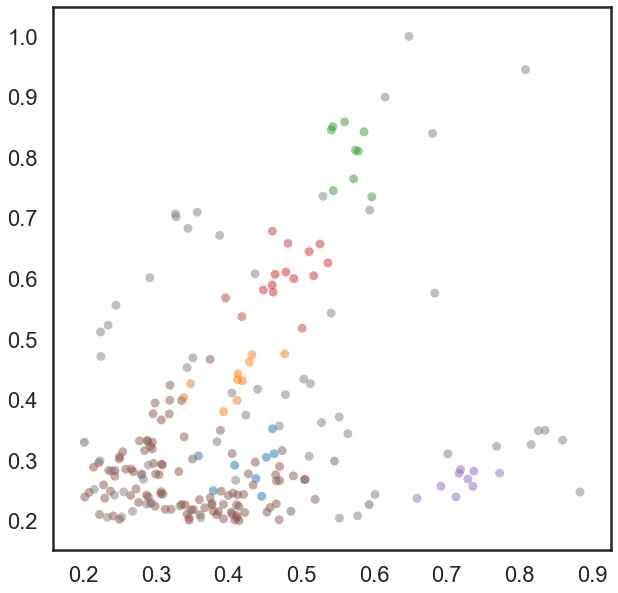

In [11]:
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}

plt.figure(figsize=(10,10))
palette = sns.color_palette()
cluster_colors = [sns.desaturate(palette[col], sat)
                  if col >= 0 else (0.5, 0.5, 0.5) for col, sat in
                  zip(clusterer.labels_, clusterer.probabilities_)]
plt.scatter(rgb_data.T[0], rgb_data.T[1], c=cluster_colors, **plot_kwds)

In [12]:
label_dict = dict(zip(df2['cell_index'],clusterer.labels_))
prob_dict = dict(zip(df2['cell_index'],clusterer.probabilities_))

df['c_label'] = df['cell_index'].apply(lambda x:label_dict.get(x))
df['c_probability'] = df['cell_index'].apply(lambda x:prob_dict.get(x))

In [13]:
#df.to_csv('test files\hdb_results.csv',index=False)